In [1]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import math

import matplotlib.cm as cm
import matplotlib.pyplot as plt

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# Read data from excel. 
fd = 'mops2022data.xlsx'
survey1 = pd.read_excel( fd, sheet_name=0 )

survey1.columns

Index([                                                        'Sample',
                                                          'Response No',
                                  'Low rise  - as opposed to high rise',
                             'Social rent - as opposed to higher rents',
                                                 'Lots of space inside',
              'Accomodates physical disabilities e.g. step-free access',
                    'Family friendly - having units with more bedrooms',
                                                 'Low carbon footprint',
                       'Community spaces e.g. play areas, youth centre',
                                                          'Green space',
                                                                'Other',
                                                       'Please specify',
                                                                      1,
                                                   

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

In [5]:
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [6]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

{'an', 'been', 'into', 'any', "you've", 'those', 'weren', 'have', 'didn', 'too', "doesn't", 'your', 'above', 'a', 'i', "it's", "haven't", 'down', 'should', "couldn't", 'ours', 'by', 'd', 'won', 'than', 'did', 'theirs', 'they', 'between', 'myself', 'here', 'for', 'their', 'of', 'has', 'off', "hadn't", 'up', 'where', 'once', 'just', 'yourself', 'her', 'most', 'below', 'himself', 'be', 'themselves', 'until', 'ourselves', 'from', "don't", 'on', 'yours', "you're", 'whom', 'hadn', "wouldn't", 'how', 'do', 'few', 'over', 'she', "mustn't", 'that', 'y', "aren't", 'only', 'is', 'hers', 'after', 'itself', 'having', 'yourselves', 'are', 'while', 'or', 'through', 'as', 't', 'about', 'needn', 'this', 'shan', 'you', "she's", 'wasn', 'll', 'in', 'we', 'couldn', 'me', "shan't", 'hasn', 'against', 'was', 'why', 'herself', 'to', 'who', 'both', 'own', 'mustn', 'ma', 'our', 'same', "needn't", 'nor', 'with', 'will', 'he', 'again', 'my', 'wouldn', 'if', "wasn't", 'had', 'now', "that'll", 'm', 'don', "weren't

In [7]:
stop = stopwords.words('english')

In [34]:
survey1.columns = survey1.columns.str.replace("'"," ")
survey1.rename(columns={'3.Why did you rank them in this order? What do and don t you l':'Why_rank', 
                        '4.Is there anything  we ve missed about housing that you would':'more'},inplace=True)

In [35]:
survey1.replace(99, np.nan)
survey1.replace(99.0, np.nan)
survey1.replace('99', np.nan)

,Sample,Response No,Low rise - as opposed to high rise,Social rent - as opposed to higher rents,Lots of space inside,Accomodates physical disabilities e.g. step-free access,Family friendly - having units with more bedrooms,Low carbon footprint,"Community spaces e.g. play areas, youth centre",Green space,...,I live elsewhere in Hackney,I shop at Tesco,I use the car park,I m a member of a local community group,I work in Hackney,I own a local business,I study in Hackney,I have no connection to Hackney,Other.2,Please specify.3
0,1,1,0,1,0,0,1,0,1,0,...,0,1,0,1,1,0,0.0,0,0,0
1,1,2,1,1,0,0,0,1,1,0,...,0,1,0,1,1,0,0.0,0,1,"Kids are here, people want it"
2,1,8,1,1,0,1,1,1,0,1,...,0,0,0,1,1,0,0.0,0,0,0
3,1,10,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0.0,0,0,0
4,1,12,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0.0,0,1,Lived in Hackney for most of my life
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,2,616,0,0,0,0,0,1,1,1,...,0,1,0,0,0,0,0.0,0,0,0
750,2,617,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0.0,0,0,0
751,2,618,0,0,0,0,0,1,1,1,...,0,1,0,0,0,0,0.0,0,0,0
752,2,623,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99.0,99,99,99


In [36]:
# housingfb means 'housing feedback'
housingfb = [('Why_rank', 'more')]
test = pd.DataFrame(housingfb)
test.columns = ['Why_rank', 'more']

In [37]:
test.apply(lambda x: [item for item in x if item not in stop])

Why_rank    [Why_rank]
more                []
dtype: object

In [38]:
survey1.dtypes

Sample                                                              int64
Response No                                                         int64
Low rise  - as opposed to high rise                                 int64
Social rent - as opposed to higher rents                            int64
Lots of space inside                                                int64
Accomodates physical disabilities e.g. step-free access             int64
Family friendly - having units with more bedrooms                   int64
Low carbon footprint                                                int64
Community spaces e.g. play areas, youth centre                      int64
Green space                                                         int64
Other                                                               int64
Please specify                                                     object
NaN                                                                object
NaN                                   

In [39]:
survey1['more'].value_counts()

99                                                                    386
no                                                                     17
No                                                                      9
/                                                                       4
more green space                                                        3
                                                                     ... 
parking                                                                 1
not segregatting by social and high rent for access and facilities      1
children play area                                                      1
parking spaces                                                          1
Building with green plants planted on out wall                          1
Name: more, Length: 328, dtype: int64

In [40]:
survey1['Why_rank'].value_counts()

99                                                                                                      148
lowrise                                                                                                   5
appearance                                                                                                3
Design                                                                                                    3
space                                                                                                     2
                                                                                                       ... 
Number 1 looks more modern and is a personal choice                                                       1
Not interested in sharing with others                                                                     1
Enough space for people without feeling you're on top of each other                                       1
Aesthetic of the building - 

In [41]:
housingfb = survey1.loc[survey1['Why_rank'] != 99]

In [42]:
print(housingfb)

     Sample  Response No  Low rise  - as opposed to high rise  \
0         1            1                                    0   
1         1            2                                    1   
2         1            8                                    1   
3         1           10                                    0   
4         1           12                                    0   
..      ...          ...                                  ...   
697       2          382                                    1   
698       2          384                                    0   
717       2          436                                    0   
730       2          483                                    0   
753       2          251                                    0   

     Social rent - as opposed to higher rents  Lots of space inside  \
0                                           1                     0   
1                                           1                     0   
2     

In [43]:
housingfb['Why_rank'].value_counts()

lowrise                                                                                                 5
Design                                                                                                  3
appearance                                                                                              3
 the design (Aesthetics)                                                                                2
green space                                                                                             2
                                                                                                       ..
Number 1 looks more modern and is a personal choice                                                     1
Not interested in sharing with others                                                                   1
Enough space for people without feeling you're on top of each other                                     1
Aesthetic of the building - how they would fit

In [44]:
housingfb.head(10)

,Sample,Response No,Low rise - as opposed to high rise,Social rent - as opposed to higher rents,Lots of space inside,Accomodates physical disabilities e.g. step-free access,Family friendly - having units with more bedrooms,Low carbon footprint,"Community spaces e.g. play areas, youth centre",Green space,...,I live elsewhere in Hackney,I shop at Tesco,I use the car park,I m a member of a local community group,I work in Hackney,I own a local business,I study in Hackney,I have no connection to Hackney,Other.2,Please specify.3
0,1,1,0,1,0,0,1,0,1,0,...,0,1,0,1,1,0,0.0,0,0,0
1,1,2,1,1,0,0,0,1,1,0,...,0,1,0,1,1,0,0.0,0,1,"Kids are here, people want it"
2,1,8,1,1,0,1,1,1,0,1,...,0,0,0,1,1,0,0.0,0,0,0
3,1,10,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0.0,0,0,0
4,1,12,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0,0.0,0,1,Lived in Hackney for most of my life
5,1,16,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0.0,0,0,0
6,1,17,0,1,0,0,1,1,0,0,...,0,1,0,0,1,0,0.0,0,0,0
7,1,18,0,0,0,1,0,1,0,1,...,0,0,0,0,1,1,0.0,0,0,0
8,1,19,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0.0,0,0,0
9,1,21,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0.0,0,0,0


In [45]:
housingfb['Why_rank'].value_counts().head(10)

lowrise                                    5
Design                                     3
appearance                                 3
 the design (Aesthetics)                   2
green space                                2
Aesthetics                                 2
Low Rise                                   2
aesthetics                                 2
space                                      2
how they look and fit with surroundings    2
Name: Why_rank, dtype: int64

In [46]:
morefb = survey1.loc[survey1['more'] != 99]

In [47]:
morefb['more'].value_counts().head(10)

no                                                                     17
No                                                                      9
/                                                                       4
more green space                                                        3
nope                                                                    2
no development                                                          2
communal areas                                                          2
shops in around houses. Local businesses                                1
cost is most important                                                  1
developments that are genuinely co-designed with with the community     1
Name: more, dtype: int64

In [48]:
survey1['Why_ranknew'] = survey1['Why_rank'].str.split(',') 

In [49]:
survey1['Why_ranknew'].value_counts().head(10)

[lowrise]                                                5
[appearance]                                             3
[Design]                                                 3
[like modern classy look,  dislike high rise estates]    2
[space]                                                  2
[I hate highrise]                                        2
[Aesthetics]                                             2
[space,   lowrise,   green areas]                        2
[design]                                                 2
[green space]                                            2
Name: Why_ranknew, dtype: int64

<AxesSubplot:>

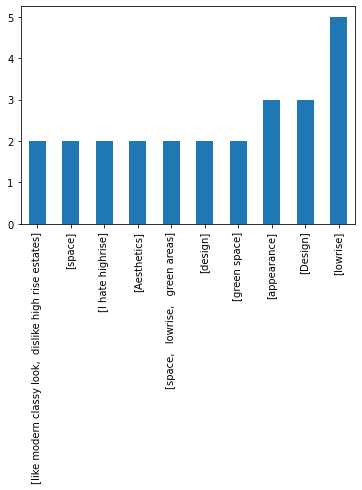

In [50]:
survey1['Why_ranknew'].value_counts().head(10).sort_values().plot(kind='bar')

In [53]:
survey1['more_new'].value_counts().head(10)

[no]                                                                     17
[No]                                                                      9
[/]                                                                       4
[more green space]                                                        3
[nope]                                                                    2
[no development]                                                          2
[communal areas]                                                          2
[shops in around houses. Local businesses]                                1
[cost is most important]                                                  1
[developments that are genuinely co-designed with with the community]     1
Name: more_new, dtype: int64

<AxesSubplot:>

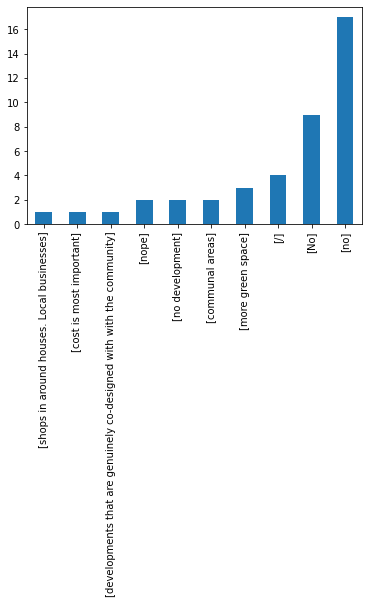

In [54]:
survey1['more_new'] = survey1['more'].str.split(',') 
survey1['more_new'].value_counts().head(10)
survey1['more_new'].value_counts().head(10).sort_values().plot(kind='bar')

## Regex Analysis

In [69]:
#random sample of responses
survey1[
    survey1.Why_rank.str.contains(r'(lowrise|low rise|highrise|high rise)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex
].Why_rank.sample(5, random_state=42)

/tmp/ipykernel_293/1258925915.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  survey1.Why_rank.str.contains(r'(lowrise|low rise|highrise|high rise)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex


578              Low rise and green space
250                        lowrise needed
476    we need more highrise accomodation
249                               lowrise
586        don’t like high rise buildings
Name: Why_rank, dtype: object

In [82]:
# looking at totals

scale = survey1[
    survey1.Why_rank.str.contains(r'(lowrise|low rise|highrise|high rise)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex
]
print(scale)
print(f"Found {scale.shape[0]:,} records for scale preferences.")

     Sample  Response No  Low rise  - as opposed to high rise  \
100       2          218                                    0   
126       2          302                                    1   
144       2          352                                    0   
189       2          542                                    0   
212       1            4                                    0   
..      ...          ...                                  ...   
614       2          383                                    1   
620       2          533                                    1   
621       2          551                                    1   
622       2          554                                    1   
675       2          227                                    0   

     Social rent - as opposed to higher rents  Lots of space inside  \
100                                         0                     0   
126                                         1                     1   
144   

/tmp/ipykernel_293/1231877523.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  survey1.Why_rank.str.contains(r'(lowrise|low rise|highrise|high rise)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex


In [83]:
design = survey1[
    survey1.Why_rank.str.contains(r'(design|Design|appearance|Appearance|Aesthetic|aesthetic)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex
]
print(design)
print(f"Found {design.shape[0]:,} records mentioning design/appearance/aesthetic.")

     Sample  Response No  Low rise  - as opposed to high rise  \
9         1           21                                    0   
14        1           47                                    0   
18        1           60                                    0   
24        1           82                                    1   
28        1           89                                    0   
..      ...          ...                                  ...   
561       2          451                                    0   
562       2          471                                    0   
565       2          477                                    0   
573       2          548                                    0   
608       2          299                                    0   

     Social rent - as opposed to higher rents  Lots of space inside  \
9                                           0                     0   
14                                          1                     0   
18    

/tmp/ipykernel_293/3606529286.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  survey1.Why_rank.str.contains(r'(design|Design|appearance|Appearance|Aesthetic|aesthetic)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex


In [84]:
greenspace = survey1[
    survey1.Why_rank.str.contains(r'(space|green space|green|community)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex
]
print(greenspace)
print(f"Found {greenspace.shape[0]:,} records mentioning space/green space/community.")

     Sample  Response No  Low rise  - as opposed to high rise  \
0         1            1                                    0   
1         1            2                                    1   
2         1            8                                    1   
4         1           12                                    0   
5         1           16                                    0   
..      ...          ...                                  ...   
592       2           74                                    0   
595       2           98                                    1   
598       2          113                                    0   
601       2          145                                    1   
605       2          199                                    0   

     Social rent - as opposed to higher rents  Lots of space inside  \
0                                           1                     0   
1                                           1                     0   
2     

/tmp/ipykernel_293/21515342.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  survey1.Why_rank.str.contains(r'(space|green space|green|community)', na=False, regex=True, flags=re.IGNORECASE) # <-- The regex
